## Problema 1  Distribucion optima de recursos  

Santigo Casasbuenas - 202214932

Amalia Carbonell - 202122079 

**1. Preprocesamiento:**
- Cambiar toneladas por Kg para las unidades de peso de los recursos (1 Tonelada = 1000Kg)
- Dejamos uniandes de volumen en m^3


**2. Definicion de conjuntos y parametros:** 
Conjuntos: 

$R$ : es el conjunto de Recursos $R =  \{r1, r2,r3,r4,r5\}$

$A$ : es el conjunto de Aviones  $A =  \{a1, a2, a3\}$

- (j ∈ J)(j recorre alimentos )

- (i ∈ N)( i recorre nutrientes )

Parametros 

Para los recursos: 
- $V_{r}$ --> valor del recurso $r$ 
- $P_{r}$ --> Peso del recurso $r$
- $M_{r}$ --> Volumen del recurso $r$

Para los aviones: 
- $K_{a}$ --> Capacidad peso del avion $a$
- $L_{a}$ --> Capacidad Volumetrica del avion $a$

**3. Variable de decision** 
$X_{ra}$ : Cantidad del recurso $r$ que va en el avion $a$ 
 - Como los equipos medicos no se pueden fraccionar planteamos una restriccion 
$X_{ra} \geq 0$ Para todo r en R y todo a en A
$X_{ra} \forall Z \geq 0 | r$ = equipos medicos 

$Y_{ra}$ : Variable binaria que indica si el recurso $r$ va en el avion $a$ 
$$ 
  Y_{ra} =
  \begin{cases} 
  1 & \text{si el recurso } r \text{ si se encuentar en el avion }a \text{} \\ 
  0 & \text{si el recurso  } j \text{ no se encuentra en el avion }a \text{}
  \end{cases} 
  $$

**4. Funcion objetivo**
-   Maximizar el valor total de los recursos transportados. Es decir, asignar los recursos a los aviones de tal manera que cada avion lleve el mayor valor posible 
-   $$\max \left( \sum_{a \in A} \sum_{r \in R} V_r \cdot X_{r,a} \right)$$

### 5. Restricciones  

**1. Restricción de peso de un avión**  
La suma de los pesos $p_{r}$ de los recursos no debe exceder la capacidad de peso del avión $K_{a}$.  
Esto aplica para todos los aviones:  

$$
\sum_{r \in R} p_r \cdot X_{r,a} \leq k_a, \quad \forall a \in A
$$

**2. Restricción de volumen de un avión**
La suma de los volúmenes $m_{r}$ de los recursos no debe exceder la capacidad volumétrica del avión $L_{a}$.  
Esto aplica para todos los aviones:  

$$
\sum_{r \in R} m_r \cdot X_{r,a} \leq L_a, \quad \forall a \in A
$$

**3. Medicinas no pueden estar en el avión 1**
Pensamos en dos posibles soluciones usando las variables de decisión:  

Opción 1:  

$$ X_{r,a} = 0, \quad \forall r \in R, \quad r = \text{medicinas}, \quad \forall a \in A, \quad a = 1 $$

Opción 2:  

$$ Y_{r,a} = 0, \quad \forall r \in R, \quad r = \text{medicinas}, \quad \forall a \in A, \quad a = 1 $$

**4.  Restricción de compatibilidad**  
Los recursos "equipos médicos" y "agua potable" no pueden ir en el mismo avión. Aplica para todos los aviones:  

$$ Y_{e_m, a} + Y_{a_p, a} \leq 1, \quad \forall a \in A $$

**5. Restriccion capacidad**
Para todos los recursos, la sumatoria de lo que se envia debe ser menor o igual a la sumatoria del peso de los recursos 
$$ X_{r,a} \leq \sum_{r \in R} P_{r}, \quad \forall a \in A$$

Estado del solver: ok
Condición de terminación: optimal
Valor óptimo (función objetivo): 680.0

=== Recursos Fraccionables (solución) ===
                        Cantidad
Recurso          Avion          
Mantas           1           1.0
                 2           0.0
                 3           1.0
AguaPotable      1           0.0
                 2           0.0
                 3           0.0
AlimentosBasicos 1           0.0
                 2           0.0
                 3           0.0
Medicinas        1           0.0
                 2           0.0
                 3           0.0

=== Recursos Enteros (solución) ===
                      Cantidad
Recurso        Avion          
EquiposMedicos 1           1.0
               2           2.0
               3           2.0


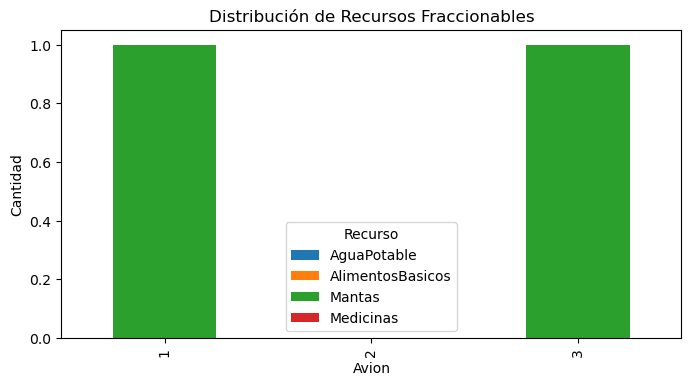

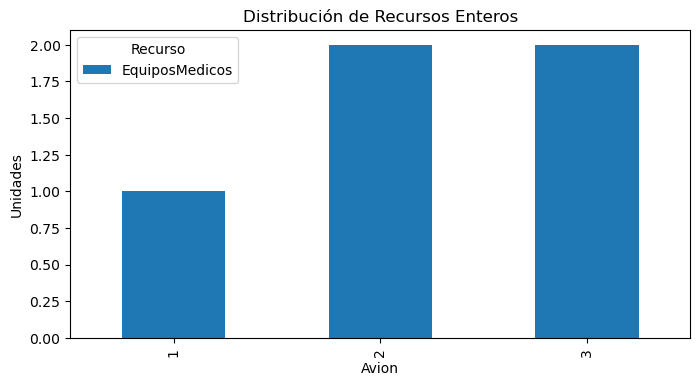

In [2]:
from pyomo.environ import (ConcreteModel, Set, Param, Var, 
                           NonNegativeReals, NonNegativeIntegers, 
                           Objective, maximize, Constraint, SolverFactory)
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# a. Inicializar el modelo
# -------------------------------------------------------------------------
model = ConcreteModel("MisionHumanitaria")

# -------------------------------------------------------------------------
# b. Definir los conjuntos y parámetros basándose en la información del problema
# -------------------------------------------------------------------------

resources_data = {
    'AlimentosBasicos': {'value': 50, 'weight': 15, 'volume': 8,  'fraccionable': True},
    'Medicinas':        {'value': 10, 'weight': 5,  'volume': 2,  'fraccionable': True},
    'EquiposMedicos':   {'value': 120,'weight': 20, 'volume': 10, 'fraccionable': False},
    'AguaPotable':      {'value': 60, 'weight': 18, 'volume': 12, 'fraccionable': True},
    'Mantas':           {'value': 40, 'weight': 10, 'volume': 6,  'fraccionable': True}
}

planes_data = {
    1: {'weight_capacity': 30, 'volume_capacity': 25},
    2: {'weight_capacity': 40, 'volume_capacity': 30},
    3: {'weight_capacity': 50, 'volume_capacity': 35}
}

# Definir conjuntos
model.R = Set(initialize=resources_data.keys(), doc="Conjunto de recursos")
model.P = Set(initialize=planes_data.keys(), doc="Conjunto de aviones")

# Parámetros
model.value = Param(model.R, initialize=lambda model, r: resources_data[r]['value'])
model.weight = Param(model.R, initialize=lambda model, r: resources_data[r]['weight'])
model.volume = Param(model.R, initialize=lambda model, r: resources_data[r]['volume'])

model.weight_capacity = Param(model.P, initialize=lambda model, p: planes_data[p]['weight_capacity'])
model.volume_capacity = Param(model.P, initialize=lambda model, p: planes_data[p]['volume_capacity'])

# Separar recursos fraccionables y enteros
fraccionables = {r for r in model.R if resources_data[r]['fraccionable']}
enteros = {r for r in model.R if not resources_data[r]['fraccionable']}

# Variables de decisión
model.x_frac = Var(fraccionables, model.P, domain=NonNegativeReals, doc="Cantidad fraccionable de cada recurso en cada avión")
model.x_int  = Var(enteros, model.P, domain=NonNegativeIntegers, doc="Cantidad entera de cada recurso en cada avión")

# -------------------------------------------------------------------------
# d. Función objetivo
# -------------------------------------------------------------------------
def objetivo_rule(model):
    return (sum(model.value[r] * model.x_frac[r, p] for r in fraccionables for p in model.P) +
            sum(model.value[r] * model.x_int[r, p] for r in enteros for p in model.P))

model.obj = Objective(rule=objetivo_rule, sense=maximize)

# -------------------------------------------------------------------------
# e. Restricciones
# -------------------------------------------------------------------------

# Restricción de capacidad de peso
def weight_constraint_rule(model, p):
    return (sum(model.weight[r] * model.x_frac[r, p] for r in fraccionables) +
            sum(model.weight[r] * model.x_int[r, p] for r in enteros)) <= model.weight_capacity[p]

model.weight_constraints = Constraint(model.P, rule=weight_constraint_rule)

# Restricción de capacidad de volumen
def volume_constraint_rule(model, p):
    return (sum(model.volume[r] * model.x_frac[r, p] for r in fraccionables) +
            sum(model.volume[r] * model.x_int[r, p] for r in enteros)) <= model.volume_capacity[p]

model.volume_constraints = Constraint(model.P, rule=volume_constraint_rule)

# Restricción de límite de recursos disponibles
def limite_recursos_rule(model, r):
    return (sum(model.x_frac[r, p] for p in model.P if r in fraccionables) +
            sum(model.x_int[r, p] for p in model.P if r in enteros)) <= 10  # Ajusta este valor según disponibilidad

model.limite_recursos = Constraint(model.R, rule=limite_recursos_rule)

# -------------------------------------------------------------------------
# f. Resolver el modelo
# -------------------------------------------------------------------------
solver = SolverFactory('glpk')
results = solver.solve(model)

print("Estado del solver:", results.solver.status)
print("Condición de terminación:", results.solver.termination_condition)
print("Valor óptimo (función objetivo):", model.obj())

# -------------------------------------------------------------------------
# g. Visualización de resultados
# -------------------------------------------------------------------------

# Extraer soluciones
sol_frac = {(r, p): model.x_frac[r, p].value for r in fraccionables for p in model.P}
sol_int  = {(r, p): model.x_int[r, p].value  for r in enteros for p in model.P}

# Convertir en DataFrame
df_frac = pd.DataFrame.from_dict(sol_frac, orient='index', columns=['Cantidad'])
df_frac.index = pd.MultiIndex.from_tuples(df_frac.index, names=['Recurso', 'Avion'])

df_int = pd.DataFrame.from_dict(sol_int, orient='index', columns=['Cantidad'])
df_int.index = pd.MultiIndex.from_tuples(df_int.index, names=['Recurso', 'Avion'])

print("\n=== Recursos Fraccionables (solución) ===")
print(df_frac)

print("\n=== Recursos Enteros (solución) ===")
print(df_int)

# Graficar resultados
df_frac_plot = df_frac.reset_index().pivot(index='Avion', columns='Recurso', values='Cantidad')
df_frac_plot.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribución de Recursos Fraccionables")
plt.ylabel("Cantidad")
plt.show()

df_int_plot = df_int.reset_index().pivot(index='Avion', columns='Recurso', values='Cantidad')
df_int_plot.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribución de Recursos Enteros")
plt.ylabel("Unidades")
plt.show()


In [3]:
from pyomo.environ import (ConcreteModel, Set, Param, Var, 
                           NonNegativeReals, NonNegativeIntegers, 
                           Objective, maximize, Constraint, SolverFactory)
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# a. Inicializar el modelo
# -------------------------------------------------------------------------
model = ConcreteModel("MisionHumanitaria")

# -------------------------------------------------------------------------
# b. Definir los conjuntos y parámetros basándose en la información del problema
# -------------------------------------------------------------------------

# Ejemplo de datos en diccionarios (puedes ajustarlos con tus valores reales):
resources_data = {
    'AlimentosBasicos': {'value': 50, 'weight': 15, 'volume': 8,  'fraccionable': True},
    'Medicinas':        {'value': 10,'weight': 5,  'volume': 2,  'fraccionable': True},
    'EquiposMedicos':   {'value': 120,'weight': 20, 'volume': 10, 'fraccionable': False},
    'AguaPotable':      {'value': 60, 'weight': 18, 'volume': 12, 'fraccionable': True},
    'Mantas':           {'value': 40, 'weight': 10, 'volume': 6,  'fraccionable': True}
}

planes_data = {
    1: {'weight_capacity': 30, 'volume_capacity': 25},
    2: {'weight_capacity': 40, 'volume_capacity': 30},
    3: {'weight_capacity': 50, 'volume_capacity': 35}
}

# Definimos los conjuntos
model.R = Set(initialize=resources_data.keys(), doc="Conjunto de recursos")
model.P = Set(initialize=planes_data.keys(), doc="Conjunto de aviones")

# Definimos funciones para inicializar parámetros (asociadas a cada recurso/avión)
def value_init(model, r):
    return resources_data[r]['value']

def weight_init(model, r):
    return resources_data[r]['weight']

def volume_init(model, r):
    return resources_data[r]['volume']

def weight_cap_init(model, p):
    return planes_data[p]['weight_capacity']

def volume_cap_init(model, p):
    return planes_data[p]['volume_capacity']

# Declaramos los parámetros
model.value = Param(model.R, initialize=value_init, doc="Valor de cada recurso")
model.weight = Param(model.R, initialize=weight_init, doc="Peso (ton) por unidad de cada recurso")
model.volume = Param(model.R, initialize=volume_init, doc="Volumen (m^3) por unidad de cada recurso")

model.weight_capacity = Param(model.P, initialize=weight_cap_init, doc="Capacidad de peso (ton) de cada avión")
model.volume_capacity = Param(model.P, initialize=volume_cap_init, doc="Capacidad de volumen (m^3) de cada avión")

# -------------------------------------------------------------------------
# c. Declarar las variables de decisión
#    - Algunas fraccionables (NonNegativeReals)
#    - Otras enteras (NonNegativeIntegers)
# -------------------------------------------------------------------------

fraccionables = [r for r in model.R if resources_data[r]['fraccionable']]
enteros = [r for r in model.R if not resources_data[r]['fraccionable']]

model.x_frac = Var(fraccionables, model.P, domain=NonNegativeReals, doc="Cantidad fraccionable de cada recurso en cada avión")
model.x_int  = Var(enteros,      model.P, domain=NonNegativeIntegers, doc="Cantidad entera de cada recurso en cada avión")

# -------------------------------------------------------------------------
# d. Plantear la función objetivo y las restricciones (en forma general)
# -------------------------------------------------------------------------

# Función objetivo: Maximizar la suma de valores transportados
def objetivo_rule(model):
    return ( sum(model.value[r]*model.x_frac[r,p] for r in fraccionables for p in model.P)
           + sum(model.value[r]*model.x_int[r,p]  for r in enteros      for p in model.P) )
model.obj = Objective(rule=objetivo_rule, sense=maximize)

# Restricción de capacidad de peso (ejemplo en forma general)
def weight_constraint_rule(model, p):
    return ( sum(model.weight[r]*model.x_frac[r,p] for r in fraccionables)
           + sum(model.weight[r]*model.x_int[r,p]  for r in enteros) ) <= model.weight_capacity[p]

model.weight_constraints = Constraint(model.P, rule=weight_constraint_rule, doc="Capacidad de peso por avión")

# Restricción de capacidad de volumen (ejemplo en forma general)
def volume_constraint_rule(model, p):
    return ( sum(model.volume[r]*model.x_frac[r,p] for r in fraccionables)
           + sum(model.volume[r]*model.x_int[r,p]  for r in enteros) ) <= model.volume_capacity[p]

model.volume_constraints = Constraint(model.P, rule=volume_constraint_rule, doc="Capacidad de volumen por avión")

# Restricción de seguridad: "Medicinas" no pueden ir en avión 1
# (Aquí se coloca un placeholder para no mostrar la formulación exacta)
def medicinas_seguridad_rule(model):
    # Ejemplo concreto (NO incluido en la solución final):
    # return model.x_frac['Medicinas', 1] == 0
    return Constraint.Skip
model.medicinas_seguridad = Constraint(rule=medicinas_seguridad_rule)

# Restricción de compatibilidad: "Equipos Médicos" y "Agua Potable" no pueden viajar juntos
# (Placeholder para no revelar la modelación específica)
def compatibilidad_rule(model, p):
    # Ejemplo de restricción NO lineal (NO incluido en la solución final):
    # model.x_int['EquiposMedicos', p] * model.x_frac['AguaPotable', p] == 0
    return Constraint.Skip
model.compatibilidad = Constraint(model.P, rule=compatibilidad_rule)

def limite_recursos_rule(model, a):
    return (sum(model.x_frac[r, a] for r in fraccionables) + 
            sum(model.x_int[r, a] for r in enteros)) <= sum(model.P[r] for r in model.R)

model.limite_recursos = Constraint(model.P, rule=limite_recursos_rule)



# -------------------------------------------------------------------------
# e. Configurar y ejecutar el solver adecuado y realizar análisis de la solución
# -------------------------------------------------------------------------
SolverFactory('glpk').solve(model)
results = SolverFactory('glpk').solve(model)

print("Estado del solver:", results.solver.status)
print("Condición de terminación:", results.solver.termination_condition)
print("Valor óptimo (función objetivo):", model.obj())

# -------------------------------------------------------------------------
# f. Generar visualizaciones (gráficos o tablas) para facilitar la interpretación
# -------------------------------------------------------------------------

# Extraer las soluciones de las variables
sol_frac = {(r, p): model.x_frac[r, p].value for r in fraccionables for p in model.P}
sol_int  = {(r, p): model.x_int[r, p].value  for r in enteros      for p in model.P}

# Convertir en DataFrame para visualizar
df_frac = pd.DataFrame.from_dict(sol_frac, orient='index', columns=['Cantidad'])
df_frac.index = pd.MultiIndex.from_tuples(df_frac.index, names=['Recurso', 'Avion'])

df_int = pd.DataFrame.from_dict(sol_int, orient='index', columns=['Cantidad'])
df_int.index = pd.MultiIndex.from_tuples(df_int.index, names=['Recurso', 'Avion'])

print("\n=== Recursos Fraccionables (solución) ===")
print(df_frac)

print("\n=== Recursos Enteros (solución) ===")
print(df_int)

# Ejemplo de gráficos simples
df_frac_plot = df_frac.reset_index().pivot(index='Avion', columns='Recurso', values='Cantidad')
df_frac_plot.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribución de Recursos Fraccionables")
plt.ylabel("Cantidad")
plt.show()

df_int_plot = df_int.reset_index().pivot(index='Avion', columns='Recurso', values='Cantidad')
df_int_plot.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribución de Recursos Enteros")
plt.ylabel("Unidades")
plt.show()


(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /var/folders/rx/2z7872sj27s0ywd3scy
l9km80000gn/T/ipykernel_34767/3102713789.py:113)
ERROR: Rule failed when generating expression for Constraint limite_recursos
with index 1: IndexError: Set 'P' positional indices must be integers, not str
ERROR: Constructing component 'limite_recursos' from data=None failed:
        IndexError: Set 'P' positional indices must be integers, not str


IndexError: Set 'P' positional indices must be integers, not str

# Problema 2 - Redes de Transporte

## Conjuntos:
- $O$: Es el conjunto de ciudades de origen = $O =  \{"Bogota", "Medellin"\}$


-  $D$: Es el conjunto de ciudades destino = $D =  \{"Cali","Barranquilla", "Pasto", "Tunja", "Cucuta","Manizales"\}$

## Parámetros:
- **Para las ciudades de origen:**
  - $S_{o}$: La oferta $S$ de la ciudad de origen $o$.
- **Para las ciudades de destino:**
  - $D_{d}$:  La demanda $D$ de la ciudad de destino $d$.
- **Generales:**
  - $C_{o,d}$: El costo de transporte entre la ciudad de origen $o$ y la ciudad de destino $d$.


## Variables de Decisión:
- $X_{o,d} $: Cantidad de producto $X $ que va de la ciudad de origen $o$ a la ciudad de destino $d$.
- $ X_{o,d} \in \mathbb{R}_{\geq 0} $

## Función Objetivo:
- Minimizar el costo de envío $C_{o,d}$ y garantizar el cumplimiento de la demanda en cada ciudad.

$$ \min \left( \sum_{o \in O} \sum_{d \in D} C_{o,d} \cdot X_{o,d} \right) $$

## Restricciones:
1. **Se debe garantizar que todas las demandas de las ciudades de destino \( D \) se cumplan.**
   $$
   \sum_{o \in O} X_{o,d} = D_d, \quad \forall d \in D
   $$

2. **Las ciudades de origen no pueden enviar más producto del que su oferta les permite.**
   $$
   \sum_{d \in D} X_{o,d} \leq S_o, \quad \forall o \in O
   $$

3. **No se pueden enviar cantidades negativas de producto.**
   $$
   X_{o,d} \geq 0, \quad \forall o \in O, d \in D
   $$


In [4]:
from pyomo.environ import *

# --- Definir el modelo ---
model = ConcreteModel()

# --- Conjuntos ---
model.O = Set(initialize=['Bogotá', 'Medellín'])  # Ciudades origen
model.D = Set(initialize=['Cali', 'Barranquilla', 'Pasto', 'Tunja', 'Chía', 'Manizales'])  # Ciudades destino

# --- Parámetros ---
# Oferta en cada ciudad origen
supply = {'Bogotá': 550, 'Medellín': 700}
model.S = Param(model.O, initialize=supply)

# Demanda en cada ciudad destino
demand = {'Cali': 125, 'Barranquilla': 175, 'Pasto': 225, 'Tunja': 250, 'Chía': 225, 'Manizales': 200}
model.Demand = Param(model.D, initialize=demand)

# Costos de transporte (USD/ton)
costs = {
    ('Bogotá', 'Cali'): 9999999999, ('Bogotá', 'Barranquilla'): 2.5, ('Bogotá', 'Pasto'): 1.6, 
    ('Bogotá', 'Tunja'): 1.4, ('Bogotá', 'Chía'): 0.8, ('Bogotá', 'Manizales'): 1.4,
    ('Medellín', 'Cali'): 2.5, ('Medellín', 'Barranquilla'): 9999999999, ('Medellín', 'Pasto'): 2.0, 
    ('Medellín', 'Tunja'): 1.0, ('Medellín', 'Chía'): 1.0, ('Medellín', 'Manizales'): 0.8
}
model.Cost = Param(model.O, model.D, initialize=costs, default=0)

# --- Variables de decisión ---
model.x = Var(model.O, model.D, within=NonNegativeReals)  # Cantidad de toneladas enviadas

# --- Función Objetivo (Minimizar el costo total de transporte) ---
def obj_rule(model):
    return sum(model.Cost[i, j] * model.x[i, j] for i in model.O for j in model.D)
model.obj = Objective(rule=obj_rule, sense=minimize)

# --- Restricciones ---
# Restricción de oferta
model.SupplyConstraint = ConstraintList()
for i in model.O:
    model.SupplyConstraint.add(sum(model.x[i, j] for j in model.D) <= model.S[i])

# Restricción de demanda
model.DemandConstraint = ConstraintList()
for j in model.D:
    model.DemandConstraint.add(sum(model.x[i, j] for i in model.O) == model.Demand[j])

# --- Resolver el modelo ---
solver = SolverFactory('glpk')
solver.solve(model)

# --- Mostrar resultados ---
print("\nResultados óptimos:")
for i in model.O:
    for j in model.D:
        if model.x[i, j].value > 0:
            print(f"Enviar {model.x[i, j].value:.2f} toneladas de {i} a {j}")



Resultados óptimos:
Enviar 175.00 toneladas de Bogotá a Barranquilla
Enviar 225.00 toneladas de Bogotá a Pasto
Enviar 100.00 toneladas de Bogotá a Chía
Enviar 125.00 toneladas de Medellín a Cali
Enviar 250.00 toneladas de Medellín a Tunja
Enviar 125.00 toneladas de Medellín a Chía
Enviar 200.00 toneladas de Medellín a Manizales


# Problema 3 - Cubrimiento del tablero con damas

## Conjuntos:
- $I = J = \{1,2,3,4,5,6,7,8\}$

## Parámetros:
- La matriz de cobertura $C_{i,j}(k,l)$ es un parámetro clave porque nos dice si una celda $(i,j)$ es cubierta por una dama en la posicion $(k,l)$
- La matriz se representa como:

  $$
  C_{i,j}(k,l) =
  \begin{cases} 
      1, & \text{si la celda } (i,j) \text{ es cubierta por la dama en la posicion} (k,l) \\
      0, & \text{si la celda } (i,j) \text{ no es cubierta por la dama en la posicion}(k,l) 
  \end{cases}
  $$

## Variable de Decisión:
- **Variable binaria** \( X_{i,j} \): Nos indica si hay o no una dama en la posicion

  $$
  X_{i,j} =
  \begin{cases} 
      1, & \text{si se coloca una dama en la posicion } (i,j)  \\
      0, & \text{si no se coloca una dama en la posicion } (i,j) 
  \end{cases}
  $$

## Función Objetivo:
- **Minimizar la cantidad de damas necesarias para cubrir todo el tablero**:

  $$
  \min \left( \sum_{i \in I} \sum_{j \in J} X_{i,j} \right)
  $$

## Restricciones:
1. **Cada celda debe ser cubierta por al menos una dama**:

   $$
   \sum_{(k,l) \in I \times J} C_{(i,j)(k,l)} \cdot X_{i,j} \geq 1, \quad \forall (i,j) \in I \times J
   $$

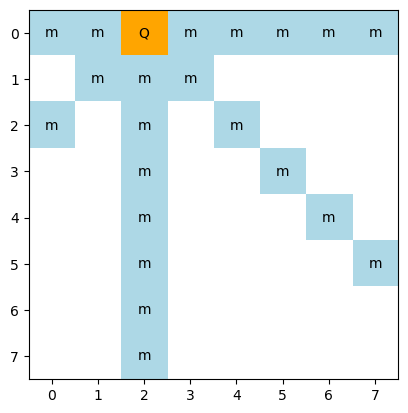

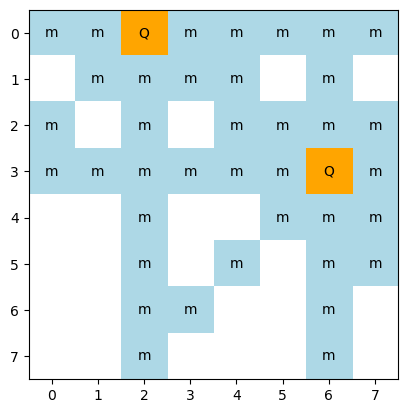

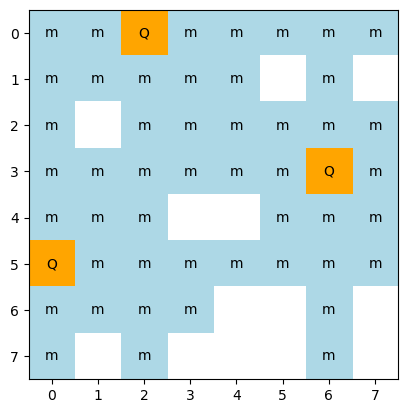

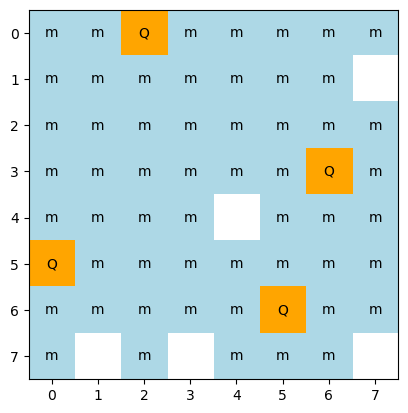

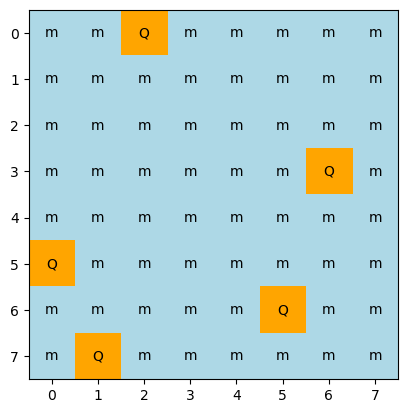

Se necesitan mínimo 5 damas para cubrir todo el tablero.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from matplotlib.colors import ListedColormap

# Definir el modelo en Pyomo
model = ConcreteModel()

# Conjuntos
model.I = RangeSet(8)  # Filas
model.J = RangeSet(8)  # Columnas

# Variables de decisión
model.x = Var(model.I, model.J, within=Binary)

# Función objetivo (minimizar la cantidad de damas)
model.obj = Objective(expr=sum(model.x[i, j] for i in model.I for j in model.J), sense=minimize)

# Restricciones
def cobertura_rule(model, i, j):
    return sum(model.x[k, l] for k in model.I for l in model.J if (k == i or l == j or abs(k-i) == abs(l-j))) >= 1

model.cobertura = Constraint(model.I, model.J, rule=cobertura_rule)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model)

def generar_matriz_cobertura(fila, columna, tamaño=8):
    """
    Genera una matriz de cobertura para una dama en una posición dada.
    """
    # Inicializar una matriz vacía de tamaño 8x8
    tablero = np.zeros((tamaño, tamaño), dtype=int)
    
    # Marcar la fila y columna
    tablero[fila, :] = 1  # Horizontal
    tablero[:, columna] = 1  # Vertical
    
    # Marcar las diagonales
    for k in range(-tamaño, tamaño):
        if 0 <= fila + k < tamaño and 0 <= columna + k < tamaño:
            tablero[fila + k, columna + k] = 1
        if 0 <= fila + k < tamaño and 0 <= columna - k < tamaño:
            tablero[fila + k, columna - k] = 1
    
    # Marcar la posición de la dama con un valor especial (2)
    tablero[fila, columna] = 2
    return tablero

def visualizar_matriz(tablero):
    """Visualiza la matriz de cobertura con Matplotlib."""
    # Se define un cmap personalizado:
    # Valor 0 -> "white" (sin cobertura)
    # Valor 1 -> "lightblue" (casilla cubierta)
    # Valor 2 -> "orange" (dama) 
    #cmap = ListedColormap(['white', 'lightblue', 'orange'])
    #plt.imshow(tablero, cmap=cmap, origin='upper')
    for i in range(tablero.shape[0]):
        if 0 not in tablero[i]:
            cmap = ListedColormap(['lightblue', 'orange'])
            plt.imshow(tablero, cmap=cmap, origin='upper')
        else:
            cmap = ListedColormap(['white', 'lightblue', 'orange'])
            plt.imshow(tablero, cmap=cmap, origin='upper')
        for j in range(tablero.shape[1]):
            if tablero[i, j] == 2:
                text = 'Q'
            elif tablero[i, j] == 1:
                text = 'm'
            else:
                text = ''
            plt.text(j, i, text, ha='center', va='center', color='black')
    plt.xticks(range(8))
    plt.yticks(range(8))
    plt.grid(False)
    plt.show()

# Extraer la solución
tablero_solucion = np.zeros((8, 8), dtype=int)
num_damas = 0
for i in model.I:
    for j in model.J:
        if model.x[i, j].value == 1:
            num_damas = num_damas + 1
            tablero_solucion[i-1, j-1] = 2  # Marcar dama en la solución
            tablero_solucion = np.maximum(tablero_solucion, generar_matriz_cobertura(i-1, j-1))
            visualizar_matriz(tablero_solucion)

print(f"Se necesitan mínimo {num_damas} damas para cubrir todo el tablero.")

# Problema 4 - Red de Nodos, Mínimo Costo

## Conjuntos:
- $N$: El conjunto de nodos: $N = \{1,2,3,4,5,6,7\}$

## Parámetros:
- $ C_{i,j} $: Costo del enlace que va del nodo $i$ al nodo $j$.

## Variables de Decisión:
- $X_{i,j}$: Es una variable binaria que indica si el enlace entre el nodo $i$ y el nodo $j$ pertenece a la ruta de costo mínimo:

  $$ X_{i,j} =
  \begin{cases} 
      1, & \text{si el enlace } (i,j) \text{ hace parte de la ruta} \\
      0, & \text{de lo contrario}
  \end{cases}
  $$

## Función Objetivo:
- Minimizar o encontrar el camino de minimo costo para ir desde el nodo 4 hasta el nodo 6:

  $$
  \min \left( \sum_{i \in N} \sum_{j \in N} X_{i,j} \cdot C_{i,j} \right)
  $$

## Restricciones:

1. **Conservación del flujo en nodos intermedios**:  
   - "Todo lo que entra a un nodo intermedio debe salir del nodo intermedio":

   $$
   \sum_{j \in N} X_{i,j} - \sum_{j \in N} X_{j,i} = 0, \quad \forall i \in N | \quad i \neq 4 \wedge i \neq 6
   $$

2. **Desde el nodo de inicio solo puede salir un camino óptimo**:

   $$
   \sum_{j \in N} X_{i,j} = 1, \quad \forall i \in N \quad | i = 4
   $$

3. **Al nodo final solo puede llegar un camino óptimo**:

   $$
   \sum_{i \in N} X_{i,j} = 1, \quad \forall j \in N \quad |  j = 6
   $$


In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cálculo de la distancia euclidiana entre nodos

# Función para calcular la distancia euclidiana entre dos puntos
def distancia_euclidiana(xi, yi, xj, yj):
    return ((xi - xj)**2 + (yi - yj)**2)**(1/2)

# Coordenadas de los nodos
nodos = {
    1: (20, 6),
    2: (22, 1),
    3: (9, 2),
    4: (3, 25),
    5: (21, 10),
    6: (29, 2),
    7: (14, 12)
}

# Umbral de conexión (Restricción)
umbral = 20

nodos_lista = list(nodos.keys())
num_nodos = len(nodos_lista)
matriz_distancias = np.zeros((num_nodos, num_nodos))

costos ={}

for i in range(num_nodos):
    for j in range(num_nodos):
        if i != j:
            xi, yi = nodos[nodos_lista[i]]
            xj, yj = nodos[nodos_lista[j]]
            distancia = distancia_euclidiana(xi, yi, xj, yj)
            if distancia <= umbral:
                matriz_distancias[i, j] = distancia
                costos[(nodos_lista[i], nodos_lista[j])] = distancia
            else:
                costos[(nodos_lista[i], nodos_lista[j])] = 99999
        else:
            costos[(nodos_lista[i], nodos_lista[j])] = 99999

                
                
print(costos)
                
                
df_distancias = pd.DataFrame(matriz_distancias, index=nodos_lista, columns=nodos_lista)
df_distancias



{(1, 1): 99999, (1, 2): 5.385164807134504, (1, 3): 11.704699910719626, (1, 4): 99999, (1, 5): 4.123105625617661, (1, 6): 9.848857801796104, (1, 7): 8.48528137423857, (2, 1): 5.385164807134504, (2, 2): 99999, (2, 3): 13.038404810405298, (2, 4): 99999, (2, 5): 9.055385138137417, (2, 6): 7.0710678118654755, (2, 7): 13.601470508735444, (3, 1): 11.704699910719626, (3, 2): 13.038404810405298, (3, 3): 99999, (3, 4): 99999, (3, 5): 14.422205101855956, (3, 6): 20.0, (3, 7): 11.180339887498949, (4, 1): 99999, (4, 2): 99999, (4, 3): 99999, (4, 4): 99999, (4, 5): 99999, (4, 6): 99999, (4, 7): 17.029386365926403, (5, 1): 4.123105625617661, (5, 2): 9.055385138137417, (5, 3): 14.422205101855956, (5, 4): 99999, (5, 5): 99999, (5, 6): 11.313708498984761, (5, 7): 7.280109889280518, (6, 1): 9.848857801796104, (6, 2): 7.0710678118654755, (6, 3): 20.0, (6, 4): 99999, (6, 5): 11.313708498984761, (6, 6): 99999, (6, 7): 18.027756377319946, (7, 1): 8.48528137423857, (7, 2): 13.601470508735444, (7, 3): 11.18033

,1,2,3,4,5,6,7
1,0.000000,5.385165,11.704700,0.000000,4.123106,9.848858,8.485281
2,5.385165,0.000000,13.038405,0.000000,9.055385,7.071068,13.601471
3,11.704700,13.038405,0.000000,0.000000,14.422205,20.000000,11.180340
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.029386
5,4.123106,9.055385,14.422205,0.000000,0.000000,11.313708,7.280110
6,9.848858,7.071068,20.000000,0.000000,11.313708,0.000000,18.027756
7,8.485281,13.601471,11.180340,17.029386,7.280110,18.027756,0.000000


Model unknown

  Variables:
    x : Size=49, Index=[1:7]*[1:7]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (1, 6) :     0 :   0.0 :     1 : False : False : Binary
        (1, 7) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4) :     0 :   0.0 :     1 : False : False : Binary
        (2, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 6) :     0 :   0.0 :     1 : False : False : Binary
        (2, 7) :     0 :   0.0 :     1 : 

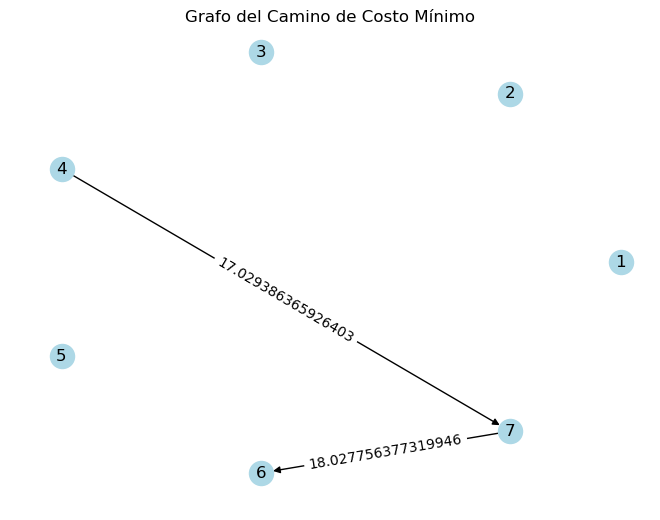

In [ ]:

from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory

import networkx as nx
import matplotlib.pyplot as plt

Model = ConcreteModel()


numNodes=7

N=RangeSet(1, numNodes)

cost = {
        (1, 1): 99999, (1, 2): 5.385164807134504, (1, 3): 11.704699910719626, (1, 4): 99999, (1, 5): 4.123105625617661, (1, 6): 9.848857801796104, (1, 7): 8.48528137423857, 
        (2, 1): 5.385164807134504, (2, 2): 99999, (2, 3): 13.038404810405298, (2, 4): 99999, (2, 5): 9.055385138137417, (2, 6): 7.0710678118654755, (2, 7): 13.601470508735444, 
        (3, 1): 11.704699910719626, (3, 2): 13.038404810405298, (3, 3): 99999, (3, 4): 99999, (3, 5): 14.422205101855956, (3, 6): 20.0, (3, 7): 11.180339887498949, 
        (4, 1): 99999, (4, 2): 99999, (4, 3): 99999, (4, 4): 99999, (4, 5): 99999, (4, 6): 99999, (4, 7): 17.029386365926403, 
        (5, 1): 4.123105625617661, (5, 2): 9.055385138137417, (5, 3): 14.422205101855956, (5, 4): 99999, (5, 5): 99999, (5, 6): 11.313708498984761, (5, 7): 7.280109889280518, 
        (6, 1): 9.848857801796104, (6, 2): 7.0710678118654755, (6, 3): 20.0, (6, 4): 99999, (6, 5): 11.313708498984761, (6, 6): 99999, (6, 7): 18.027756377319946, 
        (7, 1): 8.48528137423857, (7, 2): 13.601470508735444, (7, 3): 11.180339887498949, (7, 4): 17.029386365926403, (7, 5): 7.280109889280518, (7, 6): 18.027756377319946, (7, 7): 99999
        }

# Variables
Model.x = Var(N,N, domain=Binary)

# funcion Objetivo
Model.obj = Objective(expr = sum(Model.x[i,j]*cost[i,j] for i in N for j in N))

# Restricciones
Model.res1=ConstraintList()
for i in N:
    if i==4:
        Model.res1.add(sum(Model.x[i,j] for j in N)==1)

Model.res2=ConstraintList()
for j in N:
    if j==6:
        Model.res2.add(sum(Model.x[i,j] for i in N)==1)

Model.res3=ConstraintList()
for i in N:
    if i!=4 and i!=6:
        Model.res3.add(sum(Model.x[i,j] for j in N) - sum(Model.x[j,i] for j in N)==0)
    
# solcer
SolverFactory('glpk').solve(Model)

Model.display()


# Construir grafo de los arcos seleccionados
G = nx.DiGraph()
G.add_nodes_from(N)

for i in N:
    for j in N:
        if Model.x[i,j].value == 1 and cost[i,j] < 99999:
            G.add_edge(i, j, weight=cost[i,j])

# Calcular posiciones y dibujar
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Grafo del Camino de Costo Mínimo")
plt.show()
